In [115]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import odeint
from scipy import stats
import random
from scipy.stats.mstats import mquantiles
import scipy
import math
from matplotlib import cm
from mpl_toolkits import mplot3d
import pandas as pd
from scipy.stats import truncnorm
from statsmodels.graphics.tsaplots import plot_acf
import scipy.optimize as optimize
sns.set_style("darkgrid")


In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

MessageError: ignored

In [ ]:
%cd gdrive/MyDrive

[Errno 107] Transport endpoint is not connected: 'gdrive/MyDrive'
/content/gdrive/MyDrive


# Generación de datos:

\begin{equation}
    \begin{split}
		\dot{S} &= -\beta S \frac{I}{N}\\
    \dot{E} &= \beta S \frac{I}{N}-\lambda E\\
		\dot{I} &= \lambda E-\gamma I\\
    \dot{Y} &= \beta S \frac{I}{N}\\
		\dot{R} &= \gamma I\\
    \end{split}
\end{equation}
donde $\beta, \lambda,\gamma>0$.

In [138]:
def SEIR(X,t, be,mu,ga,de):
    S,I,Y,D,R = X
    dS = -be*S*I-mu*S
    dI = be*I*S - I*(mu+ga+de)
    dY = be*I*S
    dD = de*I
    dR = ga*I-mu*R
    Xsol = np.array([dS,dI,dY,dD,dR],dtype='float64')
    Xsol = Xsol.reshape(5,)
    return(Xsol)

Si se quieren cargar datos observados de un archivo de texto se puede usar 

In [139]:
# data1 = np.loadtxt('datos_inci.txt', skiprows = 0) #los datos vienen de un SEIR 

En nuestro caso los vamos a simular

In [140]:
theta_real = [0.5, 0.6, 1,0.4]
print(theta_real)

[0.5, 0.6, 1, 0.4]


In [141]:
N = 20000. #Tamano de la poblaci'on
S0 = N-1.
I0 = 1
Y0 = 1.
D0 = 0.
R0 = 0.

X0 = S0, I0, Y0, D0, R0
print(X0)
dias = 7
tiem = np.linspace(0, 7, 201)  ## vector de tiempos
#print(tiem)

(19999.0, 1, 1.0, 0.0, 0.0)


In [142]:
solucion =  odeint(func=SEIR, y0=X0, t=tiem, args=(theta_real[0],theta_real[1],theta_real[2],theta_real[3]))
print(np.shape(solucion))
print(np.sum(solucion[200,[0,1,2,4]]))  #Una forma de checar que está bien definida la función

(201, 5)
20202.341434680373


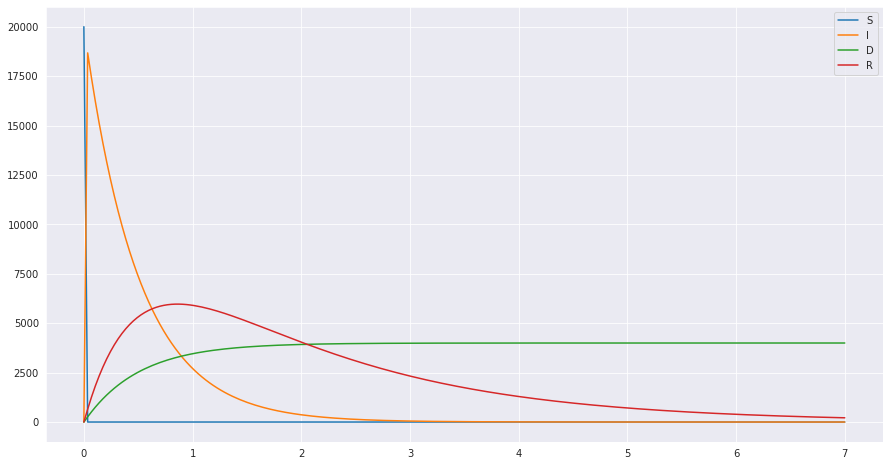

In [143]:
S, I, Y, D, R = solucion.T
plt.figure(figsize=(15, 8))
plt.plot(tiem,S, label='S')
plt.plot(tiem,I, label='I')
#plt.plot(tiem,Y, label='Y')
plt.plot(tiem,D, label='D')
plt.plot(tiem,R, label='R')
plt.legend(loc="best")
plt.show()

Seleccionamos los datos de incidencia, agregamos por intervalos de tiempo y agregamos ruido

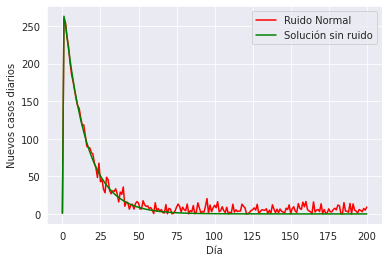

In [158]:
incidencia=np.diff(solucion[:,3])
#Agregamos ruido normal a la incidencia 
solruido3=abs(incidencia+np.random.normal(size=incidencia.shape,scale=7))
#Simulamos la incidencia con ruido Poisson
#solruido2=np.random.poisson(incidencia,incidencia.shape)
#Agregamos la condición incial al vector de incidencias ya que por defecto no lo incluye
solincdias=np.concatenate((np.array([I0]),solruido3))
#solincdias2=np.concatenate((np.array([I0]),solruido2))
SOLincdias=np.concatenate((np.array([I0]),incidencia))
#Graficas de nuevos casos diario con y sin ruido
plt.figure()
plt.plot(solincdias, '-r', label='Ruido Normal')
#pl.plot(solincdias2, '-b', label='Ruido Poisson' )
plt.plot(SOLincdias,'-g',label="Solución sin ruido")
plt.legend(loc=0)
plt.xlabel('Día')
plt.ylabel('Nuevos casos diarios')
plt.show()

In [159]:
def loss_funNorm(params): 
    """Logaritmo de la función de perdida cuadratica para los datos de incidencia
    con ruido Normal para el vector de parametros params"""
    be,mu,ga,de = params
    SOL = odeint(SEIR,y0=X0,t=tiem,args=(be,mu,ga,de))
    incidencia=np.diff(solucion[:,3])
    SOLincdias=np.concatenate((np.array([I0]),incidencia))
    loss = np.log(np.sum((SOLincdias-solincdias)**2)/200)
    return np.array([loss])


In [160]:
initial_guess=np.array([0.5,0.2,0.5,0.2]) 
#Le decimos los intervalos donde busco los valores que minimizan
bnds= ((0.00001, 1), (0.00001, 1),(0.0001, 1),(0.000001, 1))
result = optimize.minimize(loss_funNorm,initial_guess,bounds=bnds,method='Nelder-Mead')
paramNorm=result.x #parametros estimados para incidencias de ruido Normal
SOLNorm = odeint(SEIR,y0=X0,t=tiem,args=tuple(paramNorm))#Solución con parametros estimados
IncajusteNorm=np.concatenate((np.array([I0]),np.diff(SOLNorm[:,3])))#Incidencia con parametros estimados
print("Parametros Ajuste Normal:",paramNorm)

Parametros Ajuste Normal: [0.5 0.2 0.5 0.2]


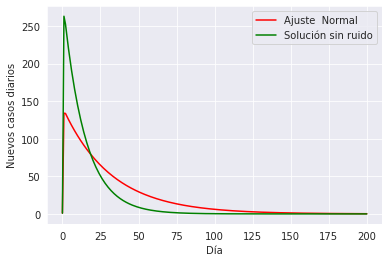

In [161]:
plt.figure()
plt.plot(IncajusteNorm, '-r', label='Ajuste  Normal ')
#plt.plot(IncajustePois, '-b', label='Ajuste con Ruido Poisson' )
plt.plot(SOLincdias,'-g',label="Solución sin ruido")
plt.legend(loc=0)
plt.xlabel('Día')
plt.ylabel('Nuevos casos diarios')
plt.show()

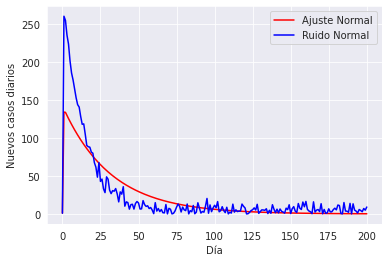

In [165]:
plt.figure()
plt.plot(IncajusteNorm, '-r', label='Ajuste Normal')
plt.plot(solincdias, '-b', label='Ruido Normal' )
plt.legend(loc=0)
plt.xlabel('Día')
plt.ylabel('Nuevos casos diarios')
plt.show()

In [15]:
tiem


array([  0.  ,   0.25,   0.5 ,   0.75,   1.  ,   1.25,   1.5 ,   1.75,
         2.  ,   2.25,   2.5 ,   2.75,   3.  ,   3.25,   3.5 ,   3.75,
         4.  ,   4.25,   4.5 ,   4.75,   5.  ,   5.25,   5.5 ,   5.75,
         6.  ,   6.25,   6.5 ,   6.75,   7.  ,   7.25,   7.5 ,   7.75,
         8.  ,   8.25,   8.5 ,   8.75,   9.  ,   9.25,   9.5 ,   9.75,
        10.  ,  10.25,  10.5 ,  10.75,  11.  ,  11.25,  11.5 ,  11.75,
        12.  ,  12.25,  12.5 ,  12.75,  13.  ,  13.25,  13.5 ,  13.75,
        14.  ,  14.25,  14.5 ,  14.75,  15.  ,  15.25,  15.5 ,  15.75,
        16.  ,  16.25,  16.5 ,  16.75,  17.  ,  17.25,  17.5 ,  17.75,
        18.  ,  18.25,  18.5 ,  18.75,  19.  ,  19.25,  19.5 ,  19.75,
        20.  ,  20.25,  20.5 ,  20.75,  21.  ,  21.25,  21.5 ,  21.75,
        22.  ,  22.25,  22.5 ,  22.75,  23.  ,  23.25,  23.5 ,  23.75,
        24.  ,  24.25,  24.5 ,  24.75,  25.  ,  25.25,  25.5 ,  25.75,
        26.  ,  26.25,  26.5 ,  26.75,  27.  ,  27.25,  27.5 ,  27.75,
      

In [16]:
tt = pd.cut(tiem, bins= np.linspace(0, 100, 101))
print(tt)

[NaN, (0.0, 1.0], (0.0, 1.0], (0.0, 1.0], (0.0, 1.0], ..., (98.0, 99.0], (99.0, 100.0], (99.0, 100.0], (99.0, 100.0], (99.0, 100.0]]
Length: 401
Categories (100, interval[float64, right]): [(0.0, 1.0] < (1.0, 2.0] < (2.0, 3.0] < (3.0, 4.0] < ... <
                                             (96.0, 97.0] < (97.0, 98.0] < (98.0, 99.0] <
                                             (99.0, 100.0]]


In [17]:
print(np.shape(tt[1:]))
print(np.shape(Y_out))


(400,)
(400,)


In [18]:
key = pd.Series(tt[1:])
inc = pd.Series(Y_out)
df_key = key.to_frame()
df_inc = inc.to_frame()
df_key = df_key.rename(columns = {0:'key'})
df_inc = df_inc.rename(columns = {0:'inc'})
                                                  
df=pd.concat([df_key,df_inc],  axis=1)
print(df)
print(type(df))


               key           inc
0       (0.0, 1.0]  1.971140e+03
1       (0.0, 1.0]  1.409717e-11
2       (0.0, 1.0]  1.214403e-09
3       (0.0, 1.0] -1.270337e-09
4       (1.0, 2.0] -4.226649e-09
..             ...           ...
395   (98.0, 99.0]  0.000000e+00
396  (99.0, 100.0]  0.000000e+00
397  (99.0, 100.0]  0.000000e+00
398  (99.0, 100.0]  0.000000e+00
399  (99.0, 100.0]  0.000000e+00

[400 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>


In [19]:
a = df.groupby('key').sum()
a

,inc
key,
"(0.0, 1.0]",1.971140e+03
"(1.0, 2.0]",-1.019089e-09
"(2.0, 3.0]",1.455192e-10
"(3.0, 4.0]",2.887646e-11
"(4.0, 5.0]",2.773959e-11
...,...
"(95.0, 96.0]",0.000000e+00
"(96.0, 97.0]",0.000000e+00
"(97.0, 98.0]",0.000000e+00


<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
(100,)


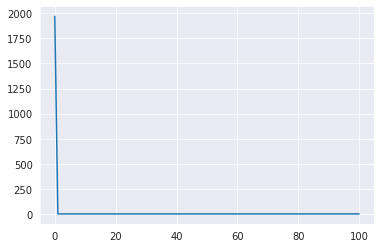

In [20]:
pd_data = df.groupby('key').sum()['inc']
print(type(pd_data))
data = pd_data.to_numpy()
print(type(data))
print(np.shape(data))
plt.plot(np.linspace(0, 100, 100),data)

Ahora añadimos algo de ruido

In [21]:
np.random.seed(478) 
plt.figure(figsize=(15, 8))
#Ydat = np.copy(data)+30*np.random.standard_normal(120).reshape(60,2)
Ydat=np.random.poisson(lam=data, size=data.shape[0])
plt.plot(np.linspace(0, 100, 100),data, label='Incidencia diaria exacta')
plt.plot(np.linspace(0, 100, 100),Ydat,'bo',label='Incidencia diara con ruido')
plt.legend(loc="best")

ValueError: ignored

<Figure size 1080x576 with 0 Axes>

***A prior, Verosimilitud, Posterior (sin vectorizar):***

In [195]:
par1=[2.5,0,0.3]  #hiperpar'ametros para beta
par2=[5,0,0.3]  #hiperpar'ametros para mu
par3=[1.2,0,0.5]  #hiperpar'ametros para gamma
par4=[1.2,0,0.5]  # hiperparametros para delta

def logaprioris(theta):
    be,mu,ga,de = theta
    dbe = scipy.stats.gamma.logpdf(be,par1[0],par1[1],par1[2])
    dmu = scipy.stats.gamma.logpdf(mu,par2[0],par2[1],par2[2])
    dga = scipy.stats.gamma.logpdf(ga,par3[0],par3[1],par3[2])
    dde = scipy.stats.gamma.logpdf(de,par4[0],par4[1],par4[2])
    return(dbe+dmu+dga+dde)


La parametrización de la densidad que scipy considera es
$$
f(x, \alpha, \beta)=\frac{\beta^\alpha x^{\alpha-1} e^{-\beta x}}{\Gamma(\alpha)}
$$
con el comeando gamma.pdf(x, a, loc, scale), donde 'a' corresponde a $\alpha$ y 'loc' =0 y scale = $1 / \beta$.

  


In [175]:
scipy.stats.gamma.pdf(0.5, 0.6, 0.1)

0.6493927618239241

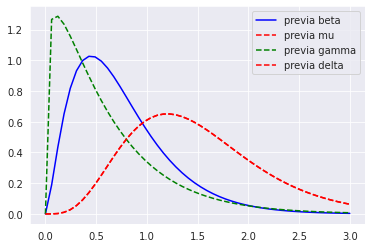

In [176]:
par1=[2.5,0,0.3]  #hiperpar'ametros para beta
par2=[5,0,0.3]  #hiperpar'ametros para mu
par3=[1.2,0,0.5]  #hiperpar'ametros para gamma
par4=[1.5,0,0.5]  #hiperpar'ametros para delta
x = np.linspace(0., 3., 50)
prev1 = scipy.stats.gamma.pdf(x, par1[0],par1[1],par1[2])
prev2 = scipy.stats.gamma.pdf(x, par2[0],par2[1],par2[2])
prev3 = scipy.stats.gamma.pdf(x, par3[0],par3[1],par3[2])
prev4 = scipy.stats.gamma.pdf(x, par4[0],par4[1],par4[2])
plt.plot(x, prev1, 'b-', label='previa beta')
plt.plot(x, prev2, 'r--', label='previa mu')
plt.plot(x, prev3, 'g--', label='previa gamma')
plt.plot(x, prev2, 'r--', label='previa delta')
plt.legend(loc="best")


In [177]:
X0

(19999.0, 1, 1.0, 0.0, 0.0)

In [191]:
#### verosimilitud
def logverosimilitud(theta):
  be,mu,ga,de = theta
  dias = 100
  t = np.linspace(0,100,101)  ## vector de tiempos
  Xt =  odeint(func=SEIR, y0=X0, t=t, args=(be,mu,ga,de))
  ### Incidencia
  S,I,Y,D,R=Xt.T
  Y_out=Y[1:]-Y[:-1]
  tt=pd.cut(t,bins=np.linspace(0,100,101))
  key=pd.Series(tt[1:])
  inc=pd.Series(Y_out)
  inc=np.abs(inc)
  df_key=key.to_frame()
  df_inc=inc.to_frame()
  df_key=df_key.rename(columns={0:'key'})
  df_inc=df_inc.rename(columns={0:'inc'})
  df=pd.concat([df_key,df_inc], axis=1)
  pd_data=df.groupby('key').sum()['inc']
  data=pd_data.to_numpy()
  Ydat=scipy.stats.poisson.rvs(mu=data)
  Ydat=np.abs(Ydat)
  vers = scipy.stats.poisson.logpmf(Ydat, inc)
  ver = np.sum(vers)
  return(ver)  

#### Posterior
def logposterior(theta):
  return(logaprioris(theta)+logverosimilitud(theta))


In [192]:
def posterior(theta):
    return(np.exp(logaprioris(theta)+logverosimilitud(theta)))

In [193]:
print(theta_real)
print(logverosimilitud(theta_real))
print(logverosimilitud([0.3,0.2,0.5,0.3]))

[0.5, 0.6, 1, 0.4]
-6.250423785633757
-6.178635298860172


In [196]:
print(logposterior(theta_real))
print(logposterior([0.3,0.2,0.5,0.3]))

-8.917677883288528
-10.359020914002908


In [197]:
print(posterior(theta_real))
print(posterior([0.4,0.4,0.1,0.3]))

0.00011633329991233169
0.0004591934009697846


***Funciones para vectorizar y graficar contornos:***

In [198]:
def vectoriza(fun,lp,up,i,j,m):
  ## i,j son las entradas del vector de parám.
  ## de los parámetros que se van a graficar
  xx = np.linspace(lp[0],up[0],m)
  yy = np.linspace(lp[1],up[1],m)
  xx,yy = np.meshgrid(xx,yy)
  z = np.zeros([m,m])
  temp = par_dat.copy()
  ## los demás entrarán como parámetros
  for u in range(m):
    for v in range(m):
      temp[i] = xx[u][v]
      temp[j] = yy[u][v]
      z[u][v] = fun(temp)
  return(xx,yy,z)

Para analizar la posterior

In [199]:
### prueba: be vs. la
par_dat = [0.584,0.5,1/7.1]
xx,yy,z = vectoriza(fun = logposterior,lp = np.array([0.001,0.001]) ,up = np.array([2,2]),i=0,j=1,m=50)


ValueError: ignored

Text(0, 0.5, '$\\lambda$')

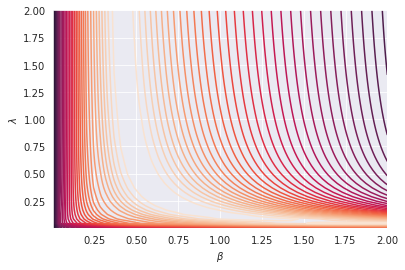

In [ ]:
CS = plt.contour(xx,yy,z,50)
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\lambda$')
#plt.clabel(CS, inline=1, fontsize=10)
#plt.savefig('Contorno',dpi = 800)

Text(0, 0.5, '$\\gamma$')

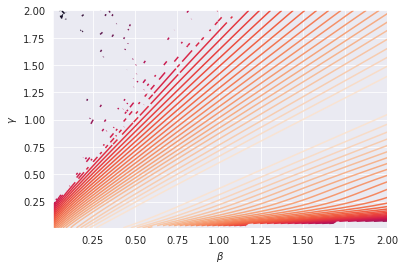

In [ ]:
### prueba: be vs. ga
xx,yy,z = vectoriza(fun = logposterior,lp = np.array([0.01,0.01]) ,up = np.array([2,2]),i=0,j=2,m=100)
plt.contour(xx,yy,z,50)
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\gamma$')
#plt.savefig('Contorno',dpi = 800)

Text(0, 0.5, '$\\gamma$')

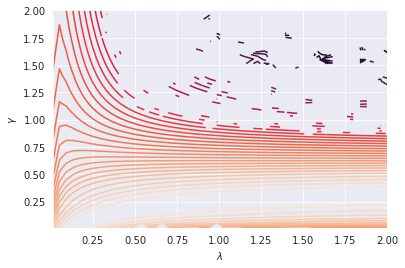

In [ ]:
### prueba: la vs. ga
xx,yy,z = vectoriza(fun = logposterior,lp = np.array([0.01,0.01]) ,up = np.array([2,2]),i=1,j=2,m=50)
plt.contour(xx,yy,z,50)
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$\gamma$')
#plt.savefig('Contorno',dpi = 800)

# MCMC

In [200]:
scipy.stats.gamma.rvs(0.6,0,1)

0.38426897702024343

In [201]:
# Genera las propuestas
def rkernelprop(present, sd, size=1):
    myclip_a = 0
    myclip_b = 1e10
    a, b = (myclip_a - present) / sd, (myclip_b - present) / sd
    proposal = truncnorm.rvs(a,b,loc = present, scale = sd, size=size)
    return(proposal)

# Reporta la densidad de la propuesta    
def dkernelprop(prop,present,sd):
    myclip_a = 0
    myclip_b = 1e10
    a, b = (myclip_a - present) /sd, (myclip_b - present) / sd
    denproposal = truncnorm.pdf(prop, a, b, loc = present, scale = sd)
    return(denproposal)

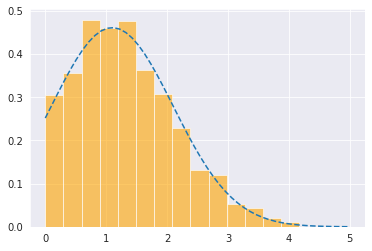

In [202]:
sims = rkernelprop(present = 1.1, sd = 1, size = 1000)
plt.hist(sims, 14 , density = True,  histtype ='bar', 
         color ='orange', alpha = 0.6)
x = np.linspace(0., 5., 50)
plt.plot(x, dkernelprop(x,1.1,1), '--')


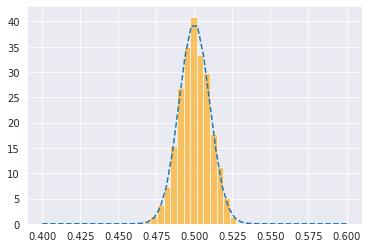

In [203]:
sims = rkernelprop(present = 0.5, sd = 0.01, size = 1000)
plt.hist(sims, 14 , density = True,  histtype ='bar', 
         color ='orange', alpha = 0.6)
x = np.linspace(.4, .6, 50)
plt.plot(x, dkernelprop(x,0.5,0.01), '--')

In [204]:
#if 3!=0:
#  if np.exp(3)>0:
#    print("hola")
if 3!=0 and np.exp(3)>0:
  print("hola")

hola


In [205]:
def inicializa():
  flag=False
  while flag==False:
    a = scipy.stats.gamma.rvs(par1[0],par1[1],par1[2])
    b = scipy.stats.gamma.rvs(par2[0],par2[1],par2[2])    
    c = scipy.stats.gamma.rvs(par3[0],par3[1],par3[2])
    d = scipy.stats.gamma.rvs(par4[0],par4[1],par4[2])
    tt = np.array([a, b, c,d])
    print("entra")
    if posterior(tt)>0:
      theta_ini = tt
      flag=True
  return(theta_ini)


Estamos asumendo que ya tenemos definido:

    par1=[2.5,0,0.3]  #hiperpar'ametros para beta
    par2=[5,0,0.3]  #hiperpar'ametros para lamba
    par3=[1.2,0,0.5]  #hiperpar'ametros para gamma

In [206]:
tt = inicializa()
tt

entra


array([0.65968216, 1.99307957, 0.07139867, 1.11036704])

Estamos asumendo que ya tenemos definido:

    N = 10000.
    S0 = N-1.
    E0 = 0.
    I0 = 1.
    Y0 = 1.
    R0 = 0.
    X0 = S0, E0, I0, Y0, R0

In [209]:
def MH(iters, theta_ini, sd):
    theta_act = theta_ini

    be_v = np.zeros(iters)          ## guardar cadenas de betas
    mu_v = np.zeros(iters)          ##guardar cadenas de mus
    ga_v = np.zeros(iters)          ##guardar cadenas de gammas
    de_v = np.zeros(iters)          ##guardar cadenas de deltas
    logposter_v = np.empty(iters)   ##guardar todas las posteriores
    
    ### primer entrada de cada cadena
    logposter_v[0] = logposterior(theta_act)
    theta_prop = [0., 0. , 0., 0.]
    actualizo = 0

    for i in range(1,iters):
        ### empieza propuesta
        theta_prop[0] = rkernelprop(present = theta_act[0], sd = sd, size=1)[0]
        theta_prop[1] = rkernelprop(present = theta_act[1], sd = sd, size=1)[0]
        theta_prop[2] = rkernelprop(present = theta_act[2], sd = sd, size=1)[0]
        theta_prop[3] = rkernelprop(present = theta_act[3], sd = sd, size=1)[0]
        #print(theta_prop)

        # alfa
        qxy = dkernelprop(theta_act[0], theta_prop[0],sd) * dkernelprop(theta_act[1], theta_prop[1],sd) * dkernelprop(theta_act[2],theta_prop[2],sd)* dkernelprop(theta_act[3],theta_prop[3],sd)  #centrada en propuesto
        qyx = dkernelprop(theta_prop[0],theta_act[0],sd) * dkernelprop(theta_prop[1],theta_act[1],sd) * dkernelprop(theta_prop[2],theta_act[2],sd)*dkernelprop(theta_prop[3],theta_act[3],sd)  #centrada en actual
    
        lognum = logposterior(theta_prop)+np.log(qxy)
        logden = logposterior(theta_act)+np.log(qyx)
        razon = np.exp(lognum - logden)
        A = min(1,razon)
        #print(A)
        #print(posterior(theta_prop), posterior(theta_act))

        if np.random.uniform(0,1,1)<A: # actualiza
          be_v[i] = theta_prop[0]
          mu_v[i] = theta_prop[1]   
          ga_v[i] = theta_prop[2]
          de_v[i] = theta_prop[3]
          logposter_v[i] = logposterior(theta_prop)
          theta_act = theta_prop.copy()
          actualizo += 1
        else: # no actualiza
          be_v[i] = theta_act[0]
          mu_v[i] = theta_act[1]   
          ga_v[i] = theta_act[2]
          de_v[i] = theta_act[3]
          logposter_v[i] = logposterior(theta_act)

    rechazo = iters-actualizo        
    theta = np.array([be_v, mu_v, ga_v,de_v])
    return(theta, logposter_v, rechazo, actualizo)


In [210]:
np.random.seed(478) 
iters = 10000

sims, logpost, rechazo, actualizo= MH(iters=iters, theta_ini = tt, sd=0.01)
%timeit sims
print('rechazó: ',rechazo)
print('actualizó: ',actualizo)

/usr/local/lib/python3.8/dist-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


31.8 ns ± 0.82 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)
rechazó:  1925
actualizó:  8075


In [211]:
a=[0,0]
print(a)
a[0]=rkernelprop(present = 0.47644143, sd = 0.001, size=1)[0]
a[1]=rkernelprop(present = 0.57644143, sd = 0.001, size=1)[0]
#print(ff)
print(a)


[0, 0]
[0.4764512913638391, 0.5767630595447459]


In [212]:
#print(type(sims))
#numpy.savetxt("sims10000.csv", sims, delimiter=",")
#numpy.savetxt("post10000.csv", post, delimiter=",")

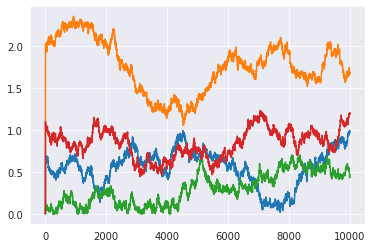

In [217]:
sims.shape
for i in range(4):
  plt.plot(sims[i,:])

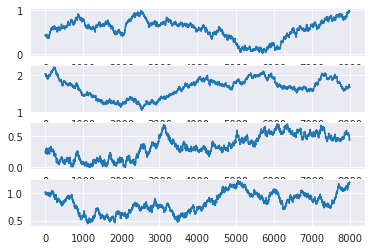

In [216]:
fig, ax = plt.subplots(4,1)
for i in range(4):
  ax[i].plot(sims[i,2000:iters])

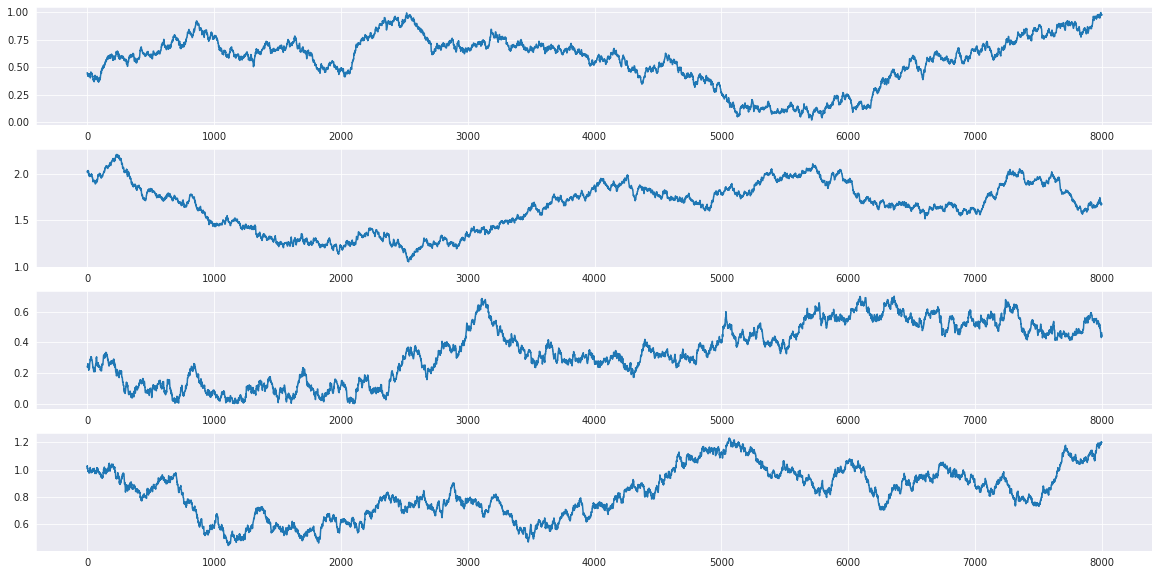

In [218]:
fig = plt.figure(figsize=(20, 10)) # create the canvas for plotting
ax1 = plt.subplot(4,1,1) # (2,1,1) indicates total number of rows, columns, and figure number respectively
ax1.plot(sims[0,2000:iters])
ax2 = plt.subplot(4,1,2)
ax2.plot(sims[1,2000:iters])
ax3 = plt.subplot(4,1,3)
ax3.plot(sims[2,2000:iters])
ax3 = plt.subplot(4,1,4)
ax3.plot(sims[3,2000:iters])

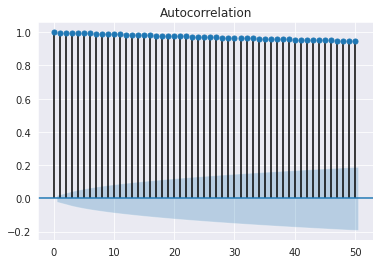

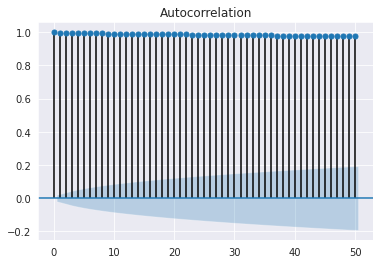

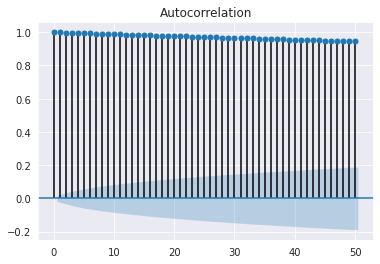

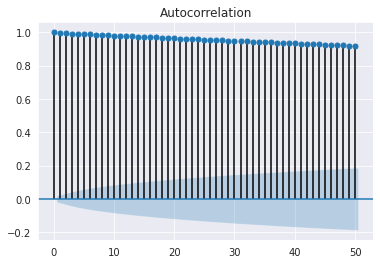

In [220]:
plot_acf(sims[0,:].tolist(), lags=50);
plot_acf(sims[1,:].tolist(), lags=50);
plot_acf(sims[2,:].tolist(), lags=50);
plot_acf(sims[3,:].tolist(), lags=50);

### En lo que sigue procedo sin hacer el adelgazamiento de la serie, pero quiero sondear rápidamente la calidad de resultados que se pueden obtener con una cadena más larga y ahora sí adelgazada. Esto último no lo hago en este codigo sino que se queda como ejercicio.

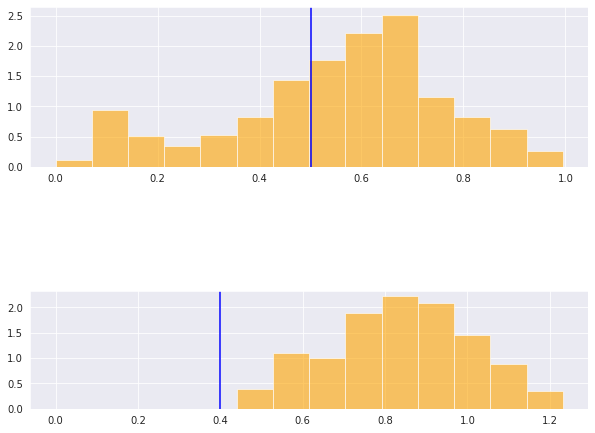

In [223]:
fig = plt.figure(figsize=(10, 10)) # create the canvas for plotting

x1 = plt.subplot(3,1,1)
plt.hist(sims[0,:], 14 , density = True,  histtype ='bar',  color ='orange', alpha = 0.6);
plt.axvline(x = theta_real[0] , color = 'b')
          
ax2 = plt.subplot(3,1,2)
plt.hist(sims[1,:], 14 , density = True,  histtype ='bar', color ='orange', alpha = 0.6);
plt.axvline(x = theta_real[1] , color = 'b')

ax3 = plt.subplot(3,1,3)
plt.hist(sims[2,:], 14 , density = True,  histtype ='bar', color ='orange', alpha = 0.6)


plt.axvline(x = theta_real[2] , color = 'b')
ax3 = plt.subplot(4,1,3)
plt.hist(sims[3,:], 14 , density = True,  histtype ='bar', color ='orange', alpha = 0.6)
plt.axvline(x = theta_real[3] , color = 'b')

In [224]:
print("Beta:   ", mquantiles(sims[0,:], prob=[0.025, 0.5, 0.975]))
print("mu: ",mquantiles(sims[1,:], prob=[0.025, 0.5, 0.975]))
print("Gamma:  ",mquantiles(sims[2,:], prob=[0.025, 0.5, 0.975]))
print("Delta:  ",mquantiles(sims[3,:], prob=[0.025, 0.5, 0.975]))
print("")
print("Verdaderos valores: ", theta_real)

Beta:    [0.0962925  0.58948173 0.90994531]
mu:  [1.21790521 1.76062452 2.26869373]
Gamma:   [0.01754207 0.28462139 0.63882486]
Delta:   [0.51429248 0.84820851 1.15073416]

Verdaderos valores:  [0.5, 0.6, 1, 0.4]


## Graficar incidencia real y ajustadas


In [226]:
curvas_aceptadas = np.zeros([8000,100])
j=0
for i in range(2000,iters):
	solucion =  odeint(func=SEIR, y0=X0, t=np.linspace(0,100,101), args=(sims[0,i], sims[1,i], sims[2,i],sims[3,i]))
	Y = solucion.T[3,:]
	curvas_aceptadas[j,:] = Y[1:]-Y[:-1]
	j +=1

/usr/local/lib/python3.8/dist-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [227]:
print(theta_real)
sims[0,900], sims[1,900], sims[2,900],sims[3,900]


[0.5, 0.6, 1, 0.4]


(0.690662851033162, 2.2919745500369073, 0.172107913995505, 0.8269732753091987)

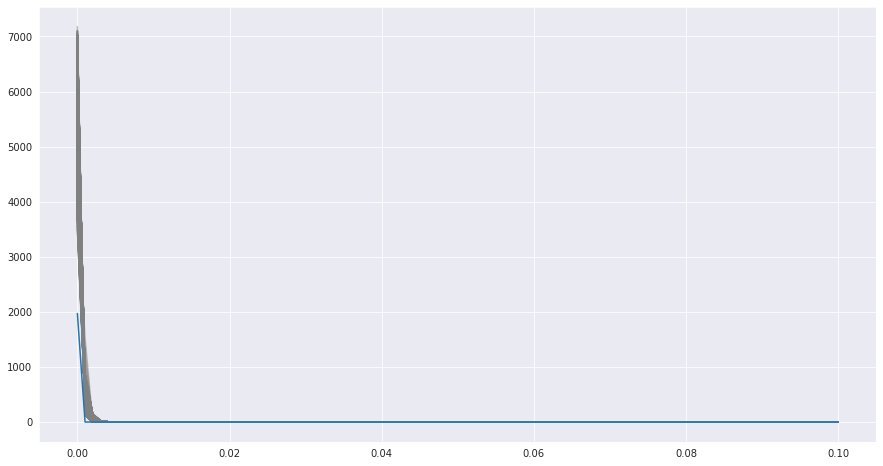

In [231]:
plt.figure(figsize=(15, 8))
for i in range(8000):
  plt.plot(np.linspace(0, 0.1, 100),curvas_aceptadas[i,:],color="grey",alpha=0.5)
plt.plot(np.linspace(0, 0.1, 100),data)
#plt.plot(np.linspace(0, 100, 100),Ydat)
##plt.plot(np.linspace(0, 100, 100),curvas_aceptadas[900,:],color="red",alpha=0.5)

In [ ]:


# unmount and mount the drive again:
!fusermount -u drive
#!google-drive-ocamlfuse drive



shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
/bin/bash: google-drive-ocamlfuse: command not found
